# Energetic analysis

This notebook contains analysis of the energetics in the simulations (cabbeling and isothermal) I have been running.

During the simulation the volume integrated kinetic energy $E_{k}$ and volume intergrated turbluent kinetic energy dissipation rate, $\epsilon$, are computed and saved.
In post processing, the potential energy $E_{p}$ and background potential energy $E_{b}$ are computed.
From these two quantities the available potential energy $E_{a}$ is then computed.

## On fly calculations

The on fly calculations are computed using [`KineticEnergy`](https://tomchor.github.io/Oceanostics.jl/dev/library/#Oceanostics.TKEBudgetTerms.KineticEnergy-NTuple{4,%20Any}) and [`KineticEnergyDissipationRate`](https://tomchor.github.io/Oceanostics.jl/dev/library/#Oceanostics.TKEBudgetTerms.KineticEnergyDissipationRate-Tuple{Any}) from [Oceanostics.jl](https://github.com/tomchor/Oceanostics.jl).
After some dimensional analysis, both the volume integrated $E_{k}$ and volume integrated $\epsilon$ need to be **multiplied by the simulation reference density** to have the correct units.

## Post processing calculations

The potential energy is computed using

$$
E_{p} = \int_{V}g\rho z\mathrm{d}V
$$

which has the correct units.
$E_{b}$ is computed in the same way but with a sort $z$ cooridinate $z_{*}$, giving correct units for this and the subsequent APE.

## Closing the energy budget

We close the energy budget using these computed terms and equations (21), (22) and (23)

$$
\begin{aligned}
\frac{\mathrm{d}E_{p}}{\mathrm{d}t} &= \Phi_{z} + \Phi_{i} \\
\frac{\mathrm{d}E_{b}}{\mathrm{d}t} &= \Phi_{d} \\
\frac{\mathrm{d}E_{a}}{\mathrm{d}t} &= \Phi_{z} - \left(\Phi_{d} - \Phi_{i}\right),
\end{aligned}
$$

and equation (9) from Winters et al. (1995),

$$
\frac{\mathrm{d}E_{k}}{\mathrm{d}t} = -\underbrace{\int_{V}g\rho w\mathrm{d}V}_{\Phi_{z}} - \epsilon.
$$

The terms are:

- $\Phi_{z}$, reversible buoyancy flux;
- $\Phi_{d}$, irreversible diapycnal mixing;
- $\Phi_{i}$, irreversible conversion of internal to potential energy.

In [1]:
cd("/g/data/e14/jb2381/CabbelingExperiments")
using Pkg
Pkg.activate(@__DIR__)
using NCDatasets, CairoMakie, TwoLayerDirectNumericalShenanigans, StatsBase, Printf

  Activating project at `/g/data/e14/jb2381/CabbelingExperiments`


In [7]:
cd("notebooks")
cabbeling_path = joinpath(pwd(), "../outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/")
isothermal_path = joinpath(pwd(), "../outputs_equaldiffusion/isothermal_stepchange_nothing_660min/")

"/g/data/e14/jb2381/CabbelingExperiments/notebooks/../outputs_equaldiffusion/isothermal_stepchange_nothing_660min/"

# Cabbeling experiments

In [60]:
cab_tracers = joinpath(cabbeling_path, "tracers.nc")
cab_computed_output = joinpath(cabbeling_path, "computed_output.nc")
cab_energetics = joinpath(cabbeling_path, "energy_diagnostics.nc")

"/g/data/e14/jb2381/CabbelingExperiments/notebooks/../outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/energy_diagnostics.nc"

In [61]:
co_ds = NCDataset(cab_computed_output)
t = co_ds[:time][:] # seconds
Δt = diff(t[1:2])
t_mins = t ./ 60
find_num = findfirst('k', co_ds.attrib["Reference density"]) - 1
ρ₀ = parse(Float64, co_ds.attrib["Reference density"][1:find_num])
dV = diff(co_ds[:xC][1:2]) .* diff(co_ds[:yC][1:2]) .* diff(co_ds[:zC][1:2])
close(co_ds)

en_ds = NCDataset(cab_energetics)
∫Eb = en_ds[:∫Eb][:] 
∫Ep = en_ds[:∫Ep][:]
∫ϵ = ρ₀ .* en_ds[:∫ϵ][:]
∫Eₖ = ρ₀ .* en_ds[:∫Eₖ][:]
close(en_ds)

closed Dataset

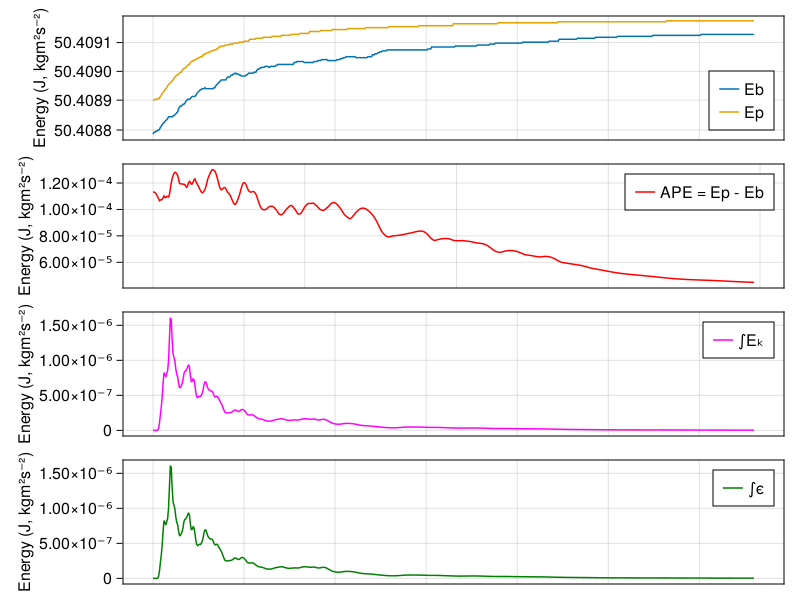

In [81]:
APE = ∫Ep .- ∫Eb
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1], xlabel = "Time (s)", ylabel = "Energy (J, kgm²s⁻²)") for i ∈ 1:4]
lines!(ax[1], t_mins, ∫Eb, label = "Eb")
lines!(ax[1], t_mins, ∫Ep, label = "Ep")
hidexdecorations!(ax[1], grid = false)
axislegend(ax[1], position = :rb)
lines!(ax[2], t, APE, color = :red, label = "APE = Ep - Eb")
axislegend(ax[2])
hidexdecorations!(ax[2], grid = false)
lines!(ax[3], t_mins, ∫Eₖ, label = "∫Eₖ", color = :magenta)
axislegend(ax[3])
hidexdecorations!(ax[3], grid = false)
lines!(ax[4], t_mins, ∫Eₖ, label = "∫ϵ", color = :green)
axislegend(ax[4])
hidexdecorations!(ax[4], grid = false)
fig

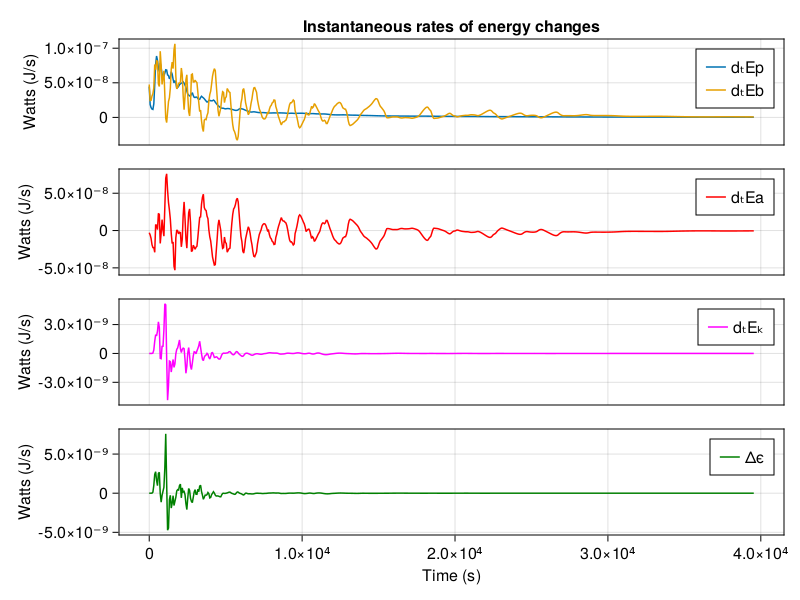

In [82]:
dₜEp = diff(∫Ep) ./ Δt
dₜEb = diff(∫Eb) ./ Δt
dₜEa = diff(∫Ep .- ∫Eb) ./ Δt
dₜEₖ = diff(∫Eₖ) ./ Δt
Δϵ = diff(∫ϵ) # This is the only term I am usure about
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1], xlabel = "Time (s)", ylabel = "Watts (J/s)") for i ∈ 1:4]
lines!(ax[1], t[1:end-1], dₜEp, label = "dₜEp")
lines!(ax[1], t[1:end-1], dₜEb, label = "dₜEb")
hidexdecorations!(ax[1], grid = false)
ax[1].title = "Instantaneous rates of energy changes"
axislegend(ax[1])
lines!(ax[2], t[1:end-1], dₜEa, color = :red, label = "dₜEa")
axislegend(ax[2])
hidexdecorations!(ax[2], grid = false)
lines!(ax[3], t[1:end-1], dₜEₖ, color = :magenta, label = "dₜEₖ")
axislegend(ax[3])
hidexdecorations!(ax[3], grid = false)
lines!(ax[4], t[1:end-1], Δϵ, color = :green, label = "Δϵ")
axislegend(ax[4])
fig

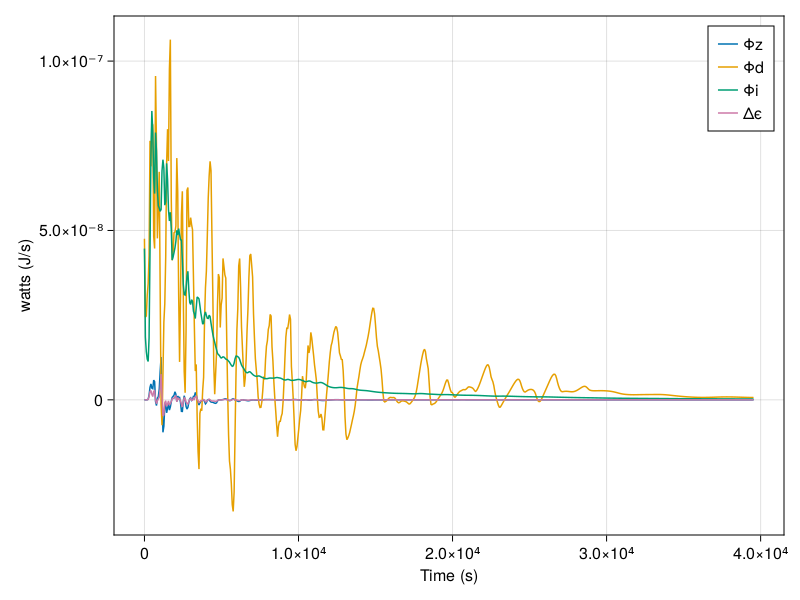

In [86]:
Φz = dₜEₖ .+ Δϵ
Φd = dₜEb
Φi = dₜEp .- Φz
fig = Figure(size = (500, 500))
ax = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "watts (J/s)")
lines!(ax, t[1:end-1], Φz, label = "Φz")
lines!(ax, t[1:end-1], Φd, label = "Φd")
lines!(ax, t[1:end-1], Φi, label = "Φi")
lines!(ax, t[1:end-1], Δϵ, label = "Δϵ")
axislegend(ax)
fig

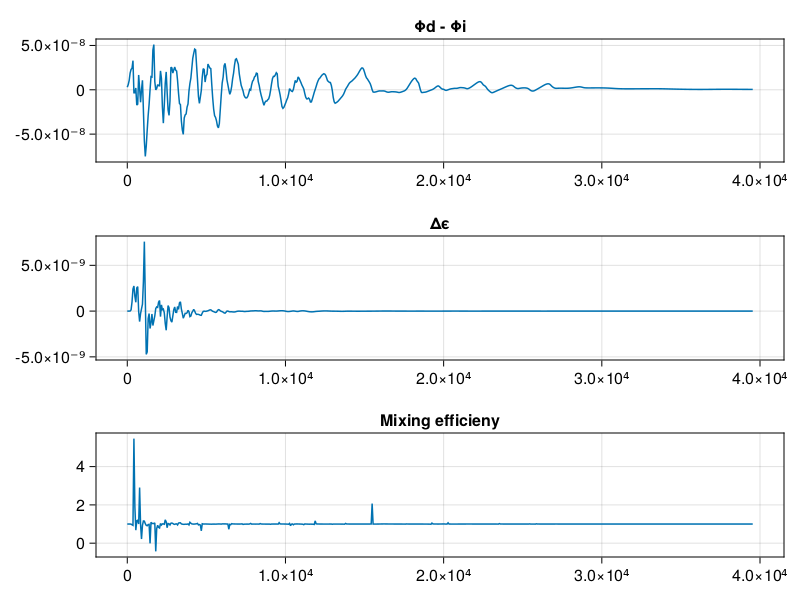

In [94]:
mixing_efficiency = @. (Φd - Φi) / (Φd - Φi + Δϵ)
fig = Figure(size = (500, 800)) 
ax = [Axis(fig[i, 1]) for i ∈ 1:3]
lines!(ax[1], t[1:end-1], Φd .- Φi)
ax[1].title = "Φd - Φi"
lines!(ax[2], t[1:end-1], Δϵ)
ax[2].title = "Δϵ"
lines!(ax[3], t[1:end-1], mixing_efficiency)
ax[3].title = "Mixing efficieny"
fig

# Isothermal experiments

In [95]:
iso_tracers = joinpath(isothermal_path, "tracers.nc")
iso_computed_output = joinpath(isothermal_path, "computed_output.nc")
iso_energetics = joinpath(isothermal_path, "energy_diagnostics.nc")

"/g/data/e14/jb2381/CabbelingExperiments/notebooks/../outputs_equaldiffusion/isothermal_stepchange_nothing_660min/energy_diagnostics.nc"

In [96]:
co_ds = NCDataset(iso_computed_output)
t = co_ds[:time][:] # seconds
Δt = diff(t[1:2])
t_mins = t ./ 60
find_num = findfirst('k', co_ds.attrib["Reference density"]) - 1
ρ₀ = parse(Float64, co_ds.attrib["Reference density"][1:find_num])
∫Eₖ = ρ₀ .* co_ds[:∫Eₖ][:]
dV = diff(co_ds[:xC][1:2]) .* diff(co_ds[:yC][1:2]) .* diff(co_ds[:zC][1:2])
close(co_ds)

en_ds = NCDataset(iso_energetics)
∫Eb = en_ds[:∫Eb][:] 
∫Ep = en_ds[:∫Ep][:]
∫ϵ = ρ₀ .* en_ds[:∫ϵ][:]
#∫Eₖ = ρ₀ .* en_ds[:∫Eₖ][:]
close(en_ds)

closed Dataset

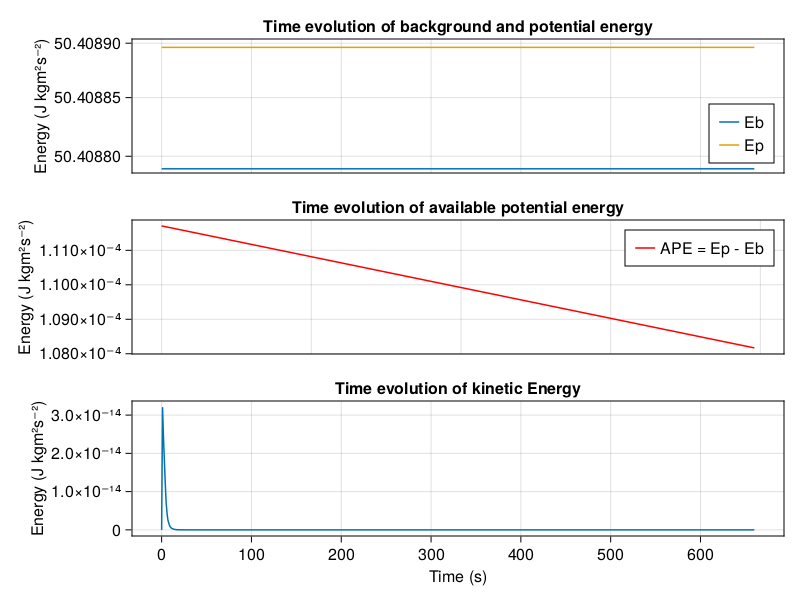

In [97]:
APE = ∫Ep .- ∫Eb
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1], xlabel = "Time (s)", ylabel = "Energy (J kgm²s⁻²)") for i ∈ 1:3]
lines!(ax[1], t_mins, ∫Eb, label = "Eb")
lines!(ax[1], t_mins, ∫Ep, label = "Ep")
hidexdecorations!(ax[1], grid = false)
ax[1].title = "Time evolution of background and potential energy"
axislegend(ax[1], position = :rb)
lines!(ax[2], t, APE, color = :red, label = "APE = Ep - Eb")
axislegend(ax[2])
hidexdecorations!(ax[2], grid = false)
ax[2].title = "Time evolution of available potential energy"
lines!(ax[3], t_mins, ∫Eₖ)
ax[3].title = "Time evolution of kinetic Energy"
fig

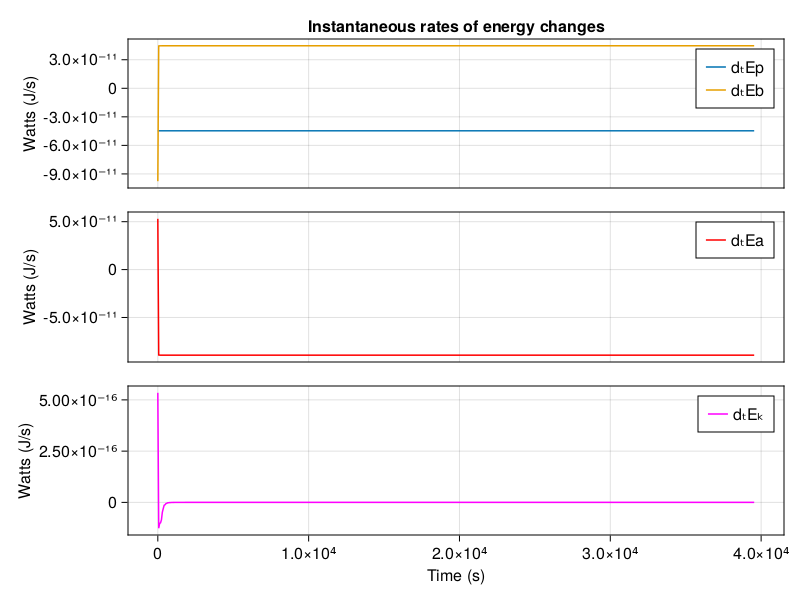

In [98]:
dₜEp = diff(∫Ep) ./ Δt
dₜEb = diff(∫Eb) ./ Δt
dₜEa = diff(∫Ep .- ∫Eb) ./ Δt
dₜEₖ = diff(∫Eₖ) ./ Δt
Δϵ = diff(∫ϵ) # This is the only term I am usure about
fig = Figure(size = (1000, 1000))
ax = [Axis(fig[i, 1], xlabel = "Time (s)", ylabel = "Watts (J/s)") for i ∈ 1:3]
lines!(ax[1], t[1:end-1], dₜEp, label = "dₜEp")
lines!(ax[1], t[1:end-1], dₜEb, label = "dₜEb")
hidexdecorations!(ax[1], grid = false)
ax[1].title = "Instantaneous rates of energy changes"
axislegend(ax[1])
lines!(ax[2], t[1:end-1], dₜEa, color = :red, label = "dₜEa")
axislegend(ax[2])
hidexdecorations!(ax[2], grid = false)
lines!(ax[3], t[1:end-1], dₜEₖ, color = :magenta, label = "dₜEₖ")
axislegend(ax[3])
fig

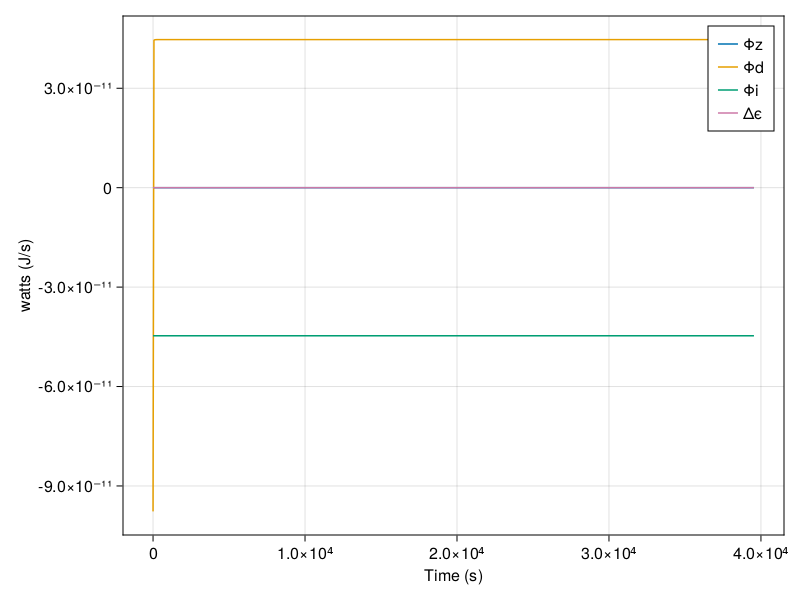

In [99]:
Φz = dₜEₖ .+ Δϵ
Φd = dₜEb
Φi = dₜEp .- Φz
fig = Figure(size = (500, 500))
ax = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "watts (J/s)")
lines!(ax, t[1:end-1], Φz, label = "Φz")
lines!(ax, t[1:end-1], Φd, label = "Φd")
lines!(ax, t[1:end-1], Φi, label = "Φi")
lines!(ax, t[1:end-1], Δϵ, label = "Δϵ")
axislegend(ax)
fig

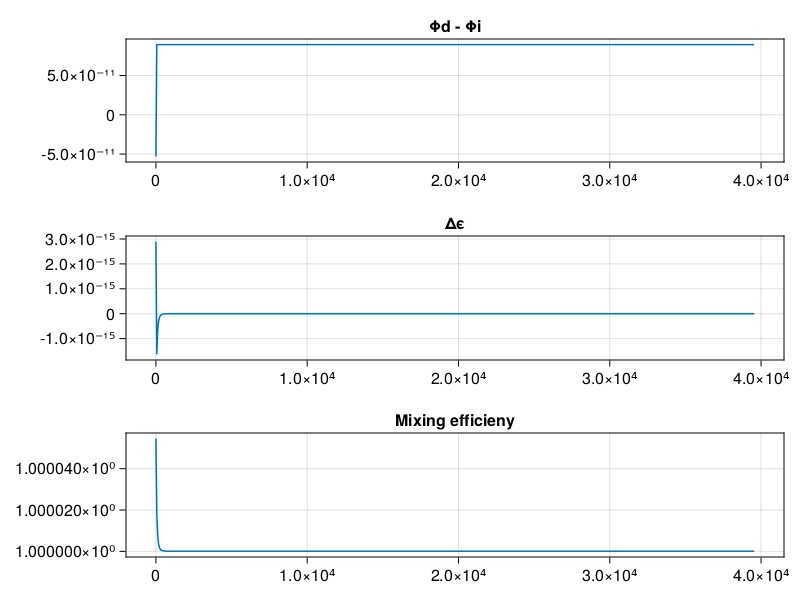

In [100]:
mixing_efficiency = @. (Φd - Φi) / (Φd - Φi + Δϵ)
fig = Figure(size = (500, 800)) 
ax = [Axis(fig[i, 1]) for i ∈ 1:3]
lines!(ax[1], t[1:end-1], Φd .- Φi)
ax[1].title = "Φd - Φi"
lines!(ax[2], t[1:end-1], Δϵ)
ax[2].title = "Δϵ"
lines!(ax[3], t[1:end-1], mixing_efficiency)
ax[3].title = "Mixing efficieny"
fig